# PetFinder.my Adoption prediction
## Udacity Data Science nano-degree capstone project

### Project overview
The project was taken from a [kaggle competition](https://www.kaggle.com/c/petfinder-adoption-prediction).
To summarize the idea: We want to improve abandoned animals welfare (especially dogs/cats) by quicker adoption. 
PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. 
Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics.
The beauty in the project is that it's well formulated, contains lots of various data types (thus allows to practice many aspects of the course) and is a real life problem.

### Problem Statement
Develop an alogrithm that ranks the adoptability of pets - specifically, **how quickly is a pet adopted**? 
This is a multiclass classification problem with 5 classes: (Although it can also be considered a regression problem)

* 0 - Pet was adopted on the same day as it was listed. 
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

#### Strategy for solving the problem
In my mind and with the knowledge from this course and Coursera deep learning specialization.
1. Build upon previous works --> Scanning through [kaggle kernels](https://www.kaggle.com/c/petfinder-adoption-prediction/kernels) of the competition in order to understand the data and get an initial working direction.
2. Exploratory data analysis. 
3. Quick and dirty classification:
    * ETL pipeline for data.
    * Use some generic classifier with small params grid search. 
    * Analysis (metrics).
4. Write down list of ideas for improvement.
5. Start work iterations in the following manner:
   * Update ETL pipeline if required. 
   * Update classification. 
   * Analysis -> Test for improvement. 
6. Repeat until close to weighted kappa score of 0.3. (Around position 1500 in leader board, though I aspire for a score of 0.4, which should ) 

### Metrics
The competition metric is the **quadratic weighted kappa (qwk)**, which measures the agreement between two ratings.
I wasn't familiar with it prior to this exercise. A nice explanation can be found [here](https://stats.stackexchange.com/questions/248583/quadratic-weighted-kappa) or [here](https://en.wikipedia.org/wiki/Cohen%27s_kappa#Weighted_kappa). Why is it justified? Accuracy could have been a good metric because by definition we're interested in accurate predictions and we're not very afraid of FN or FP (Perhaps then we'd like to use precision/recall as metrics). The **qwk** is similar to accuracy but also attempts to consider the number of accurate predictions that were derived by **chance**. 


In [297]:
# Imports
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

# Cohen Kappa score metric exists in sklearn. See discussion here:
# https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps
from sklearn.metrics import cohen_kappa_score

# Set display options in Jupyter
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Exploration

In this section we'll explore the data a bit, get some insights about it, we begin with general statistics and data related to missing/unspecified values.

In [195]:
# Get data frame
filename = 'train.csv'
df = pd.read_csv(os.getcwd() + '\\Data\\' + filename)

# Show data example
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [197]:
# Calcualte some statistics:
print('Total of %d listings in data and %d columns' % (df.shape[0], df.shape[1]))
print('Num of dogs: %d, (%2.2f%% of data)' % (df['Type'].value_counts()[1], 100*df['Type'].value_counts()[1]/df.shape[0]))
print('Num of cats: %d, (%2.2f%% of data)' % (df['Type'].value_counts()[2], 100*df['Type'].value_counts()[2]/df.shape[0]))
print('\nAdoption speeds distribution:\n%s\n' % (df['AdoptionSpeed'].value_counts()))

# How many animals per state?
index_list = df['State'].value_counts().index.tolist() # Create indices of states (StateID)
values_list = df['State'].value_counts().values.tolist() # How many animals per state
state_labels_df = pd.read_csv(os.getcwd() + '\\Data\\state_labels.csv') # Load the state labels data
states_dict = state_labels_df.set_index('StateID').to_dict()['StateName'] # Generate StateID<-->Name dictionary 
q = 0;
for state in index_list:
    print('State: %s, Animals: %d' % (states_dict[state], values_list[q]))
    q += 1

# Analyze missing values 
print('\nColumns with missing values (and how much):\n%s\n' % (df.isnull().sum()[df.isnull().sum() > 0]))

# For the the fields with "unsure/unknown"
print('Num of listings with UNSPECIFIED fur length: %d (%2.2f%%)' % 
      (df[df['FurLength'] == 0].shape[0], 100*df[df['FurLength'] == 0].shape[0]/df.shape[0]))
print('Num of listings with NOT SURE vaccination: %d (%2.2f%%)' % 
      (df[df['Vaccinated'] == 3].shape[0], 100*df[df['Vaccinated'] == 3].shape[0]/df.shape[0]))
print('Num of listings with NOT SURE dewormed: %d (%2.2f%%)' % 
      (df[df['Dewormed'] == 3].shape[0], 100*df[df['Dewormed'] == 3].shape[0]/df.shape[0]))
print('Num of listings with NOT SURE Sterilized: %d (%2.2f%%)' % 
      (df[df['Sterilized'] == 3].shape[0], 100*df[df['Sterilized'] == 3].shape[0]/df.shape[0]))
print('Num of listings with NOT Specified Health: %d (%2.2f%%)\n' % 
      (df[df['Health'] == 0].shape[0], 100*df[df['Health'] == 0].shape[0]/df.shape[0]))
    
# - How many have sentiments?
petIds = set(df['PetID'].values.tolist())
path = os.getcwd() + '\\Data\\train_sentiment'
filesList = os.listdir(path)
filesList = set( [word.split('.')[0] for word in filesList] )
num_no_listings = len(petIds) - len(petIds.intersection(filesList))
print('%d (%2.2f%%) have NO sentiment analysis\n' % (num_no_listings, 100*num_no_listings/df.shape[0]))

# How many have movies/photos?
num_listings_photo = df[df['PhotoAmt'] > 0].shape[0]
num_listings_video = df[df['VideoAmt'] > 0].shape[0]
print('%d (%2.2f%%) listings have photos' % (num_listings_photo, 100*num_listings_photo/df.shape[0]))
print('%d (%2.2f%%) listings have videos\n' % (num_listings_video, 100*num_listings_video/df.shape[0]))

# Check for duplicates
tmp = df.duplicated(subset=None, keep=False )
res = (tmp.head() == True).sum()
if (res == 0):
    print('NO DUPLICATES FOUND')
else:
    print('DUPLICATES FOUND')

Total of 14993 listings in data and 24 columns
Num of dogs: 8132, (54.24% of data)
Num of cats: 6861, (45.76% of data)

Adoption speeds distribution:
4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

State: Selangor, Animals: 8714
State: Kuala Lumpur, Animals: 3845
State: Pulau Pinang, Animals: 843
State: Johor, Animals: 507
State: Perak, Animals: 420
State: Negeri Sembilan, Animals: 253
State: Melaka, Animals: 137
State: Kedah, Animals: 110
State: Pahang, Animals: 85
State: Terengganu, Animals: 26
State: Sabah, Animals: 22
State: Kelantan, Animals: 15
State: Sarawak, Animals: 13
State: Labuan, Animals: 3

Columns with missing values (and how much):
Name           1257
Description      12
dtype: int64

Num of listings with UNSPECIFIED fur length: 0 (0.00%)
Num of listings with NOT SURE vaccination: 1868 (12.46%)
Num of listings with NOT SURE dewormed: 1781 (11.88%)
Num of listings with NOT SURE Sterilized: 1815 (12.11%)
Num of listings with NOT Specif

### Data Exploration (cnt.)
From the exploration above, we see that for the training data we have:
* Slight imbalance between dogs cats (approx. 45/55 split)
* Imbalanced labels, specifically, low number of pets adopted on the 1st day. ("Ideal scenario")
* Approximately 93% of pets in data are from 4 (out of 14) states in Malesia.
* Neglecting the name (which I don't think is relevant), there are only 12 missing descriptions. (negligble). 
* For about 12% of animals we're unsure about their vaccination/dewormed/sterlized status.
* Some listings (small fraction) don't have a Google sentiment analysis.
* Most listings have photos but only a fraction have videos.
* There are no duplicated values.

So, to summarize, in terms of the ETL pipeline, the "abnormalities" we'll have to deal with are:
* Some columns which I don't see any use of (Name, RescuerID, ...) which I'll drop. 
* few missing descriptions. (Don't care about names).
* Some missing sentiments. 
* If photo raw data is required, some missing photos. 
* Imbalances in labels. (Will impact training). 
* Encoding categorical variable columns (such as color and breed). 
* Imbalances between number of dogs/cats in database (More on that later). 
* Imbalances between number of pets per state. 

**We now continue exploring relations between parameters and adoption speed (to get a feeling) regarding what will affect the adoption speed**

NOTE: according to the following [kernel](https://www.kaggle.com/conradws/don-t-put-cats-and-dogs-in-the-same-teapot) You can see that it's recommended to separate the dogs/cats classifications. This also follows my intuition, since (as a dog owner myself) I think people are looking for different things between dogs and cats. 

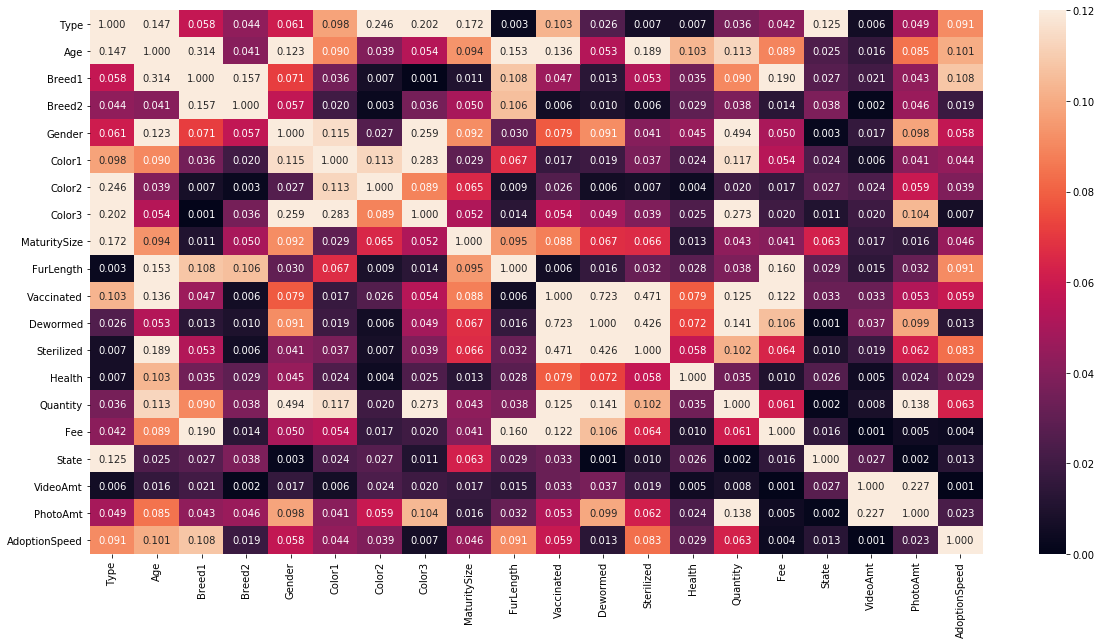

In [229]:
# First I want to examine the correlations in the data
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(np.abs(df.corr()), annot=True, fmt=".3f", ax=ax, vmin=0, vmax=0.12)

We observe some forseeable facts (vaccination/deworming and sterlization are all corellated, and also the fee. Makes sense. Money was spent on a "treated" pet so a fee is required. We can also see physical pet traits (Maturity size is related to gender. Probably males are bigger). However, all of this is nice. We want to focus on the Adoption speed correlation to the original columns. (Later we're going to add other columns...) 

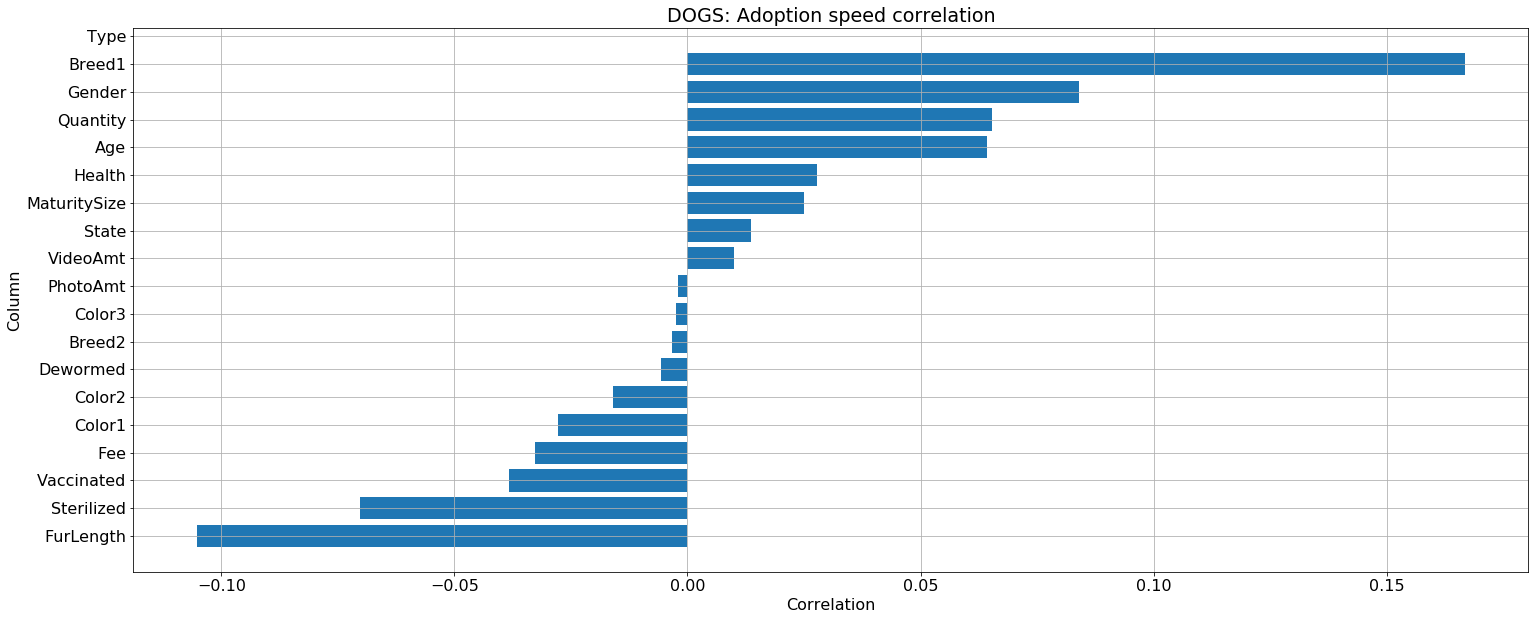

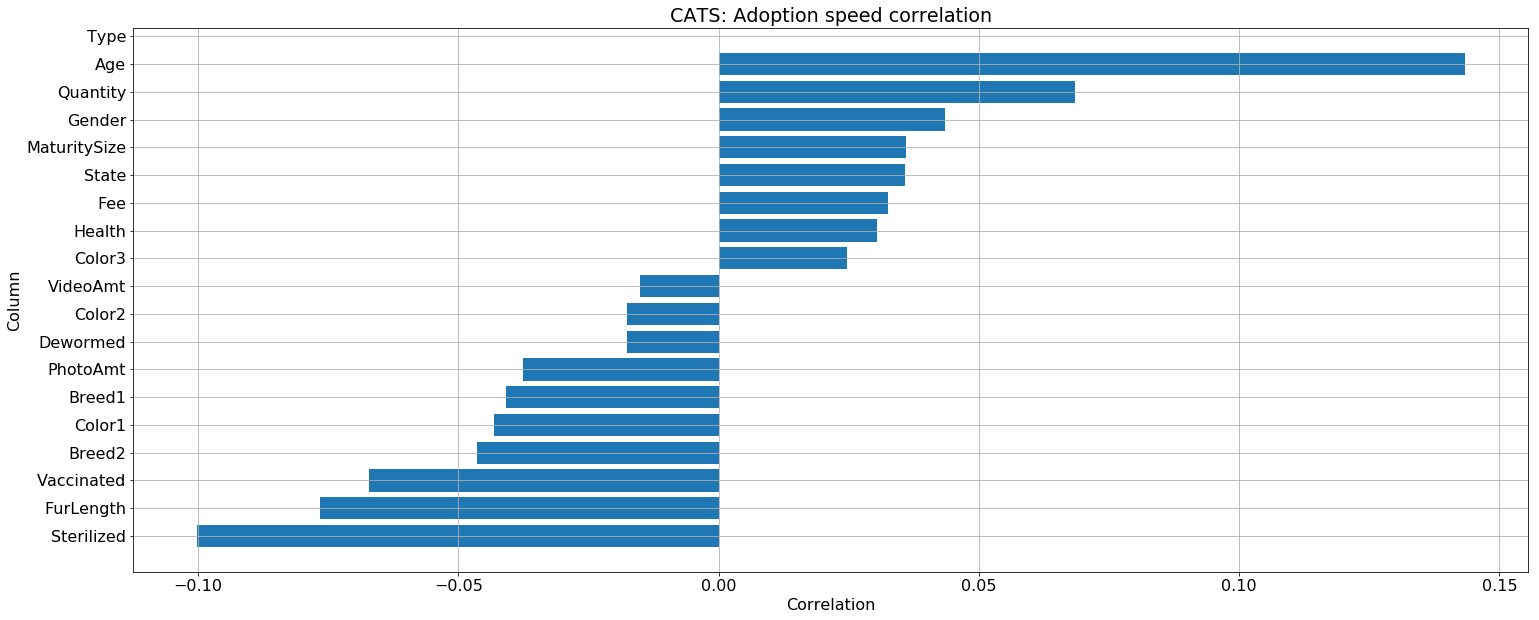

In [352]:
# Plot the Adoption speed correlation to other columns, seperating for dogs/cats
fontsize = 16
matplotlib.rcParams.update({'font.size': fontsize})
types = [1,2]
for petType in types:
    x = df[df['Type'] == petType].corr()['AdoptionSpeed'].sort_values().index.values.tolist()
    y = df[df['Type'] == petType].corr()['AdoptionSpeed'].sort_values().values.tolist()
    x.remove('AdoptionSpeed')
    y.remove(1.0)
    
    fig, ax = plt.subplots(figsize=(25,10)) 
    plt.barh(x,y)
    if petType == 1:
        plt.title('DOGS: Adoption speed correlation')
    else:
        plt.title('CATS: Adoption speed correlation')
    
    plt.grid(True)
    plt.xlabel('Correlation', fontsize = fontsize)
    plt.ylabel('Column',  fontsize = fontsize)   

# TODO: Write analysis for this plot! Add more plots



Data Visualization

Build data visualizations to further convey the information associated with your data exploration journey. Ensure that visualizations are appropriate for the data values you are plotting.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [8]:
# Stuff to do: 
# ELT --> Clean missing/duplicates


# Quick and dirty, then, using importance, exploratory
# Exploratory - some graphs and insights
# Separate to dogs/cats based on: https://www.kaggle.com/conradws/don-t-put-cats-and-dogs-in-the-same-teapot
# Use description 
# Quick and dirty classifier (Probably random forest/Adaboost)
# K-fold validation. Separately estimate for cats/dogs?
# Do we need to scale data? Normalize?
# Improvement: Create "Buckets" of similar breeds for one hot encoding of breed
# Improvement: Extract image features throuh CNN last layer chopping
# Improvement: Do my own NLP on description
# Improvement: Split also according to states
# Improvement: If only one breed --> Add binary column (pure breed)
# Improvements: Group of pets handling (Where quantity > 1)
# Improvements: Over/Undersample and show imbalances in data
# Improvements: Dimensionality reduction via PCA/ICA
# Improvements: Handle adds with quantity more than 1.

# ML pipeline for data --> Grid search?




In [ ]:
def OneHotEncodeDF(df):
    '''TODO: Write description for function here - Not the most efficient function but works'''

    ## Create dictionaries from files
    # Load files
    breed_labels_df = pd.read_csv(os.getcwd() + '\\Data\\breed_labels.csv')
    color_labels_df = pd.read_csv(os.getcwd() + '\\Data\\color_labels.csv')
    state_labels_df = pd.read_csv(os.getcwd() + '\\Data\\state_labels.csv')

    # Generate dictionaries from files
    breed1_dict = pd.Series('Breed1_' + breed_labels_df['BreedName'].values, 
                            index = breed_labels_df['BreedID']).to_dict()
    breed1_dict[0] = 'Breed1_nan'
    breed2_dict = pd.Series('Breed2_' + breed_labels_df['BreedName'].values, 
                            index = breed_labels_df['BreedID']).to_dict()
    breed2_dict[0] = 'Breed2_nan'
    color1_dict = pd.Series('Color1_' + color_labels_df['ColorName'].values,
                                  index = color_labels_df['ColorID']).to_dict()
    color2_dict = pd.Series('Color2_' + color_labels_df['ColorName'].values,
                                  index = color_labels_df['ColorID']).to_dict()
    color2_dict[0] = 'Color2_nan'
    color3_dict = pd.Series('Color3_' + color_labels_df['ColorName'].values,
                                  index = color_labels_df['ColorID']).to_dict()
    color3_dict[0] = 'Color3_nan'

    state_dict = pd.Series('State_' + state_labels_df['StateName'].values,
                                 index = state_labels_df['StateID']).to_dict()

    # Generate dictionaries manually https://www.kaggle.com/c/petfinder-adoption-prediction/data
    Gender_dict = {1: 'Gender_male', 2: 'Gender_female', 3: 'Gender_mixed'}
    MaturitySize_dict = {1: 'mSize_S', 2: 'mSize_M', 3: 'mSize_L', 4: 'mSize_XL', 0: 'mSize_nan'}
    FurLength_dict = {1: 'furLen_S', 2: 'furLen_M', 3: 'furLen_L', 0: 'furLen_nan'}
    Vaccinated_dict = {1: 'vaccinated_yes', 2: 'vaccinated_no', 3: 'vaccinated_nan'}
    Dewormed_dict = {1: 'dewormed_yes', 2: 'dewormed_no', 3: 'dewormed_nan'}
    Sterilized_dict = {1: 'sterilized_yes', 2: 'sterilized_no', 3: 'sterilized_nan'}
    Health_dict = {1: 'health_good', 2: 'health_minorInjury', 3: 'health_seriousInjury', 4: 'health_nan'}

    # Create dummy variables for all columns 
    breed1 = pd.get_dummies(df['Breed1'], prefix_sep='_')
    breed1.rename(columns=breed1_dict, inplace=True)

    breed2 = pd.get_dummies(df['Breed2'], prefix_sep='_')
    breed2.rename(columns=breed2_dict, inplace=True)

    color1 = pd.get_dummies(df['Color1'], prefix_sep='_')
    color1.rename(columns=color1_dict, inplace=True)

    color2 = pd.get_dummies(df['Color2'], prefix_sep='_')
    color2.rename(columns=color2_dict, inplace=True)

    color3 = pd.get_dummies(df['Color3'], prefix_sep='_')
    color3.rename(columns=color3_dict, inplace=True)

    state = pd.get_dummies(df['State'], prefix_sep='_')
    state.rename(columns=state_dict, inplace=True)

    Gender = pd.get_dummies(df['Gender'], prefix_sep='_')
    Gender.rename(columns=Gender_dict, inplace=True)
    MaturitySize = pd.get_dummies(df['MaturitySize'], prefix_sep='_')
    MaturitySize.rename(columns=MaturitySize_dict, inplace=True)
    FurLength = pd.get_dummies(df['FurLength'], prefix_sep='_')
    FurLength.rename(columns=FurLength_dict, inplace=True)
    Vaccinated = pd.get_dummies(df['Vaccinated'], prefix_sep='_')
    Vaccinated.rename(columns=Vaccinated_dict, inplace=True)
    Dewormed = pd.get_dummies(df['Dewormed'], prefix_sep='_')
    Dewormed.rename(columns=Dewormed_dict, inplace=True)
    Sterilized = pd.get_dummies(df['Sterilized'], prefix_sep='_')
    Sterilized.rename(columns=Sterilized_dict, inplace=True)
    Health = pd.get_dummies(df['Health'], prefix_sep='_')
    Health.rename(columns=Health_dict, inplace=True)

    # Rebuild a new dataframe with the one-hot encodings
    new_df = pd.DataFrame(data=df[['Type','Age']], index=df.index.values) 
    new_df = pd.concat([new_df, breed1, breed2, Gender, color1, color2, color3, MaturitySize, FurLength,
                        Vaccinated, Dewormed, Sterilized, Health, df[['Quantity','Fee']], state, 
                        df[['VideoAmt','PetID', 'PhotoAmt','sentiment', 'AdoptionSpeed']]], axis=1)

    return new_df

In [59]:
# Utilize Google NLP sentiment analysis to get a "score" for the description. This score will be fed into
# the classifier/regressor
def GetDescriptionSentiment(filename):
    '''Gets the json filename and returns the sentiment as weighted average of all sentiments'''
    
    # Open and read file
    fullpath = os.getcwd() + '\\Data\\train_sentiment\\' + filename
    try:
        with open(fullpath, errors='ignore') as f:
            description = json.load(f)
    except:
        return 0
    
    # Collect all scores and magnitudes
    scores, magnitudes = [],[]
    for sentence in description['sentences']:
        scores.append(sentence['sentiment']['score'])
        magnitudes.append(sentence['sentiment']['magnitude'])
        
    # Weighted score is the weighted average of scores
    w_score = 0
    L = len(scores)
    for i in range(0,L):
        w_score += (scores[i] * magnitudes[i])/L
    
    return w_score

In [169]:
def ETL_pipeline(filename, is_test_set):

    # Init
    columns_to_drop = ['Name','RescuerID']
    do_additional_nlp = 0 # Set to 1 for running an NLP function
    DOG, CAT = 1,2

    ## Load the data
    df = pd.read_csv(os.getcwd() + '\\Data\\' + filename)

    ## Drop non relevant columns (in my opinion)
    df.drop(columns_to_drop, axis=1, inplace=True)

    ## Drop rows with missing values
    # ASSUMPTION: Negligble number of such rows.
    # Todo: According to train/test data, missing values only in description. Can be handled differently since description
    # is later replaced by sentiment or other embedding...
    indices_with_nan = df[pd.isnull(df).any(axis=1)].index.values
    df.drop(labels=indices_with_nan, inplace=True)

    ## No normalization / scaling since classifier isn't going to be distance based (no Neural Network)
    
    ## No duplicates handling (I checked on train/test data)

    ## Replace description with sentiment
    sentiments = []
    for rowIdx in range(0,df.shape[0]):
        sentiments.append(GetDescriptionSentiment(df.iloc[rowIdx]['PetID']+'.json'))

    # Concatenate the sentiments to our dataframe, then drop the
    sentiments_df = pd.DataFrame({'sentiment':sentiments}, index=df.index.values)
    df = pd.concat([df, sentiments_df], axis=1, join='outer')
    if (do_additional_nlp==0):
        df.drop(labels=['Description'], inplace=True, axis=1)

    # One hot encoding for categorical variables (write function? Don't forget to drop them)
    df = OneHotEncodeDF(df)
    
    # Finished all preparations, remove petID column
    # df.drop('PetID', axis=1, inplace=True)
    
    # Split to dogs/cats data frames
    df_dogs = df[df['Type'] == DOG]
    df_dogs = df_dogs.drop('Type', axis=1) # No longer need this column
    df_cats = df[df['Type'] == CAT]
    df_cats = df_cats.drop('Type', axis=1) # No longer need this column
    
    ## Generate dataframe for labels
    if (is_test_set == 0):
        labels_dogs = pd.DataFrame(df_dogs['AdoptionSpeed'], columns=['AdoptionSpeed']) # This is a dataframe
        df_dogs.drop('AdoptionSpeed', axis=1, inplace=True)
        labels_cats = pd.DataFrame(df_cats['AdoptionSpeed'], columns=['AdoptionSpeed']) # This is a dataframe
        df_cats.drop('AdoptionSpeed', axis=1, inplace=True)
    else:
        labels_dogs, labels_cats = [],[]

    return df_dogs, df_cats, labels_dogs, labels_cats

df_dogs, df_cats, labels_dogs, labels_cats = ETL_pipeline('train.csv',0)

#ETL_pipeline('test.csv',1)

In [171]:
X = df_dogs.drop('PetID', axis=1)
y = labels_dogs['AdoptionSpeed']

#X = df_cats.drop('PetID', axis=1)
#y = labels_cats['AdoptionSpeed']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [172]:
# TODO: 
# Wrap in function
# Analysis - learn curves/

# Set the parameters by cross-validation
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [10, 100, 500]
         }

param_grid = {"base_estimator__criterion" : ["gini"],
              "base_estimator__splitter" :   ["best"],
              "n_estimators": [1000]
         }

parameters = {'nthread':[6], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [42]}

xgb_model = XGBClassifier()
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced", max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
kappa_scorer = make_scorer(cohen_kappa_score)
#clf = GridSearchCV(ABC, param_grid=param_grid, scoring = kappa_scorer, cv=5)
clf = GridSearchCV(xgb_model, param_grid=parameters, scoring = kappa_scorer, cv=6)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()


Best parameters set found on development set:

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 100, 'nthread': 6, 'objective': 'binary:logistic', 'seed': 42, 'silent': 1, 'subsample': 0.8}

Grid scores on development set:

0.220 (+/-0.033) for {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 100, 'nthread': 6, 'objective': 'binary:logistic', 'seed': 42, 'silent': 1, 'subsample': 0.8}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.42      0.23      0.30       296
           2       0.35      0.45      0.39       423
           3       0.38      0.23      0.28       398
           4       0.49      0.70      0.58       469

   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
clf.best_estimator_.feature_importances_
#df_dogs.columns.values.tolist()


array([0.02318022, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01437508, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01200647, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01458367, 0.        , 0.        , 0.02230313, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01147307, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     